In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print(tf.__version__)

2.12.0


In [3]:
import os

path = '/kaggle/input/pneumonia-chest-x-ray-dataset/test/normal'
# List all files in the directory
files = os.listdir(path)

# Get the count of files
num_files = len(files)

print(f'The number of files in the directory {path} is: {num_files}')


The number of files in the directory /kaggle/input/pneumonia-chest-x-ray-dataset/test/normal is: 234


## Image Visualization

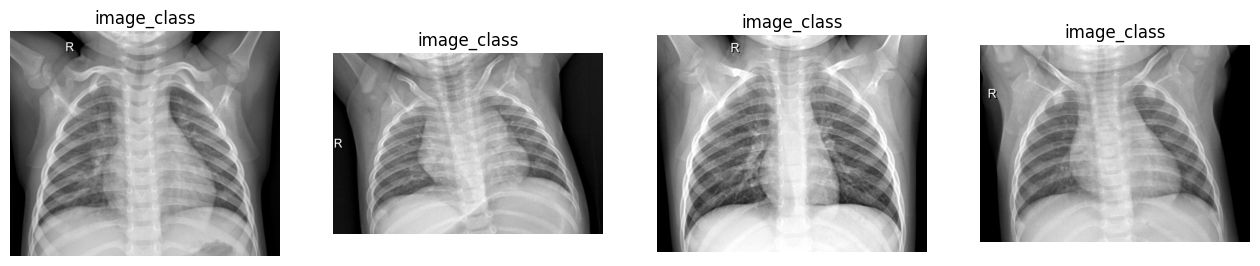

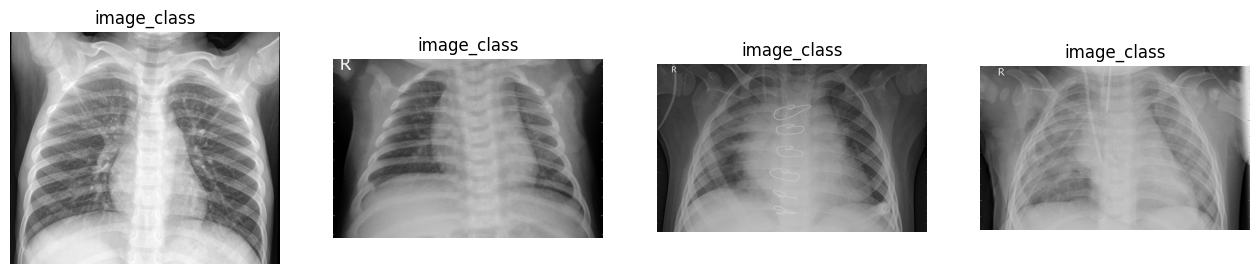

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import random

train_path = '/kaggle/input/pneumonia-chest-x-ray-dataset/train'
test_path ='/kaggle/input/pneumonia-chest-x-ray-dataset/test'
val_path = '/kaggle/input/pneumonia-chest-x-ray-dataset/val'

def image_vizualisation(path, image_class):
    plt.figure(figsize=(16,16))
    for i in range(4):
        plt.subplot(1,4,i+1)
        RandomImage = random.choice(os.listdir(path +'/'+image_class))
        img = cv2.imread(path +'/'+image_class+'/'+RandomImage)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(img)
        plt.title("image_class")
        plt.axis('off')


    plt.show()
image_vizualisation(train_path,'normal')
image_vizualisation(train_path,'pneumonia')

## Image resizing

In [5]:
# Image Resizing
import tensorflow as tf

image_size=(150,150)

def image_resizing(path,image_class):
    images = []
    for image_name in os.listdir(path+'/'+image_class):
        img = tf.keras.preprocessing.image.load_img(path+'/'+image_class+'/'+image_name, 
                                                      target_size=image_size )
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img_array)
        
    return images
normal_train_images = image_resizing(train_path, "normal")
pneumonia_train_images = image_resizing(train_path, "pneumonia")
        
    

## Data Augmentation

In [6]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

## Image Normalization

In [7]:
normal_train_images = (img/255 for img in normal_train_images)
pneumonia_train_images = (img/255 for img in pneumonia_train_images)

In [8]:
normal_train_images = list(normal_train_images)
pneumonia_train_images = list(pneumonia_train_images)

## Test Train split

In [9]:
from sklearn.model_selection import train_test_split
x_train = normal_train_images + pneumonia_train_images
y_train = [0]*len(normal_train_images) + [1]*len(pneumonia_train_images)

# Split the training data into training and validation sets
prx_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)

In [10]:
# Selecting a subset of images
def get_subset_images(path, class_name, num_images=250):
    images = []
    selected_images = random.sample(os.listdir(path + '/' + class_name), num_images)
    
    for img_name in selected_images:
        img = tf.keras.preprocessing.image.load_img(path + '/' + class_name + '/' + img_name, 
                                                    target_size=(150,150))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img_array)
    
    return images

# Get 250 images from each class
normal_train_images_subset = get_subset_images(train_path, "normal")
pneumonia_train_images_subset = get_subset_images(train_path, "pneumonia")

## Model Creation
    used Resnet_v2

In [11]:
import tensorflow_hub as hub

m = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/101-classification/versions/2")
])
m.trainable = False

In [12]:
# Create a hub.KerasLayer object for the ResNet-101 model.
hub_layer = hub.KerasLayer("https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/101-classification/versions/2")

# Add the hub.KerasLayer object to the beginning of the Keras model's layers list.
model = tf.keras.models.Sequential([
    hub_layer,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [13]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
class StopAtAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 1.0:
            print("\nReached 100% accuracy, stopping training!")
            self.model.stop_training = True

# Instantiate the custom callback
stop_at_1_accuracy = StopAtAccuracy()

In [15]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [16]:
# Combine the subset images and labels
X_train_subset = normal_train_images_subset + pneumonia_train_images_subset
y_train_subset = [0]*len(normal_train_images_subset) + [1]*len(pneumonia_train_images_subset)

# Split the subset data into training and validation sets
X_train_subset, X_val_subset, y_train_subset, y_val_subset = train_test_split(X_train_subset, y_train_subset, test_size=0.2, stratify=y_train_subset)

# Normalize the subset images
X_train_subset = [img/255.0 for img in X_train_subset]
X_val_subset = [img/255.0 for img in X_val_subset]

# Train the model using the subset data with the custom callback
history = model.fit(
    x=np.array(X_train_subset), 
    y=np.array(y_train_subset), 
    epochs=25,
    validation_data=(np.array(X_val_subset), np.array(y_val_subset)),
    callbacks=[early_stop, stop_at_1_accuracy]
)

Epoch 1/25
13/13 [==============================] - 19s 304ms/step - loss: 1.2028 - accuracy: 0.7925 - val_loss: 0.6440 - val_accuracy: 0.8700
Epoch 2/25
13/13 [==============================] - 1s 101ms/step - loss: 0.2894 - accuracy: 0.9375 - val_loss: 0.4649 - val_accuracy: 0.8400
Epoch 3/25
13/13 [==============================] - 1s 100ms/step - loss: 0.1709 - accuracy: 0.9350 - val_loss: 0.3877 - val_accuracy: 0.8800
Epoch 4/25
13/13 [==============================] - 1s 80ms/step - loss: 0.0944 - accuracy: 0.9700 - val_loss: 0.4409 - val_accuracy: 0.8700
Epoch 5/25
13/13 [==============================] - 1s 69ms/step - loss: 0.0594 - accuracy: 0.9800 - val_loss: 0.4483 - val_accuracy: 0.8800
Epoch 6/25
13/13 [==============================] - 1s 80ms/step - loss: 0.0415 - accuracy: 0.9850 - val_loss: 0.4698 - val_accuracy: 0.8800
Epoch 7/25
13/13 [==============================] - 1s 80ms/step - loss: 0.0289 - accuracy: 0.9950 - val_loss: 0.4720 - val_accuracy: 0.8800
Epoch 8/2

## Test set prediciton

In [17]:
# Preprocess the test set images
normal_test_images = image_resizing(test_path, "normal")
pneumonia_test_images = image_resizing(test_path, "pneumonia")

X_test = normal_test_images + pneumonia_test_images
y_test = [0]*len(normal_test_images) + [1]*len(pneumonia_test_images)

# Normalize the test images
X_test = [img/255.0 for img in X_test]

# Predict on the test set
y_pred_probs = model.predict(np.array(X_test))
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]

20/20 [==============================] - 2s 51ms/step


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8093
Precision: 0.7817
Recall: 0.9641
F1 Score: 0.8634


# display of Predicted 

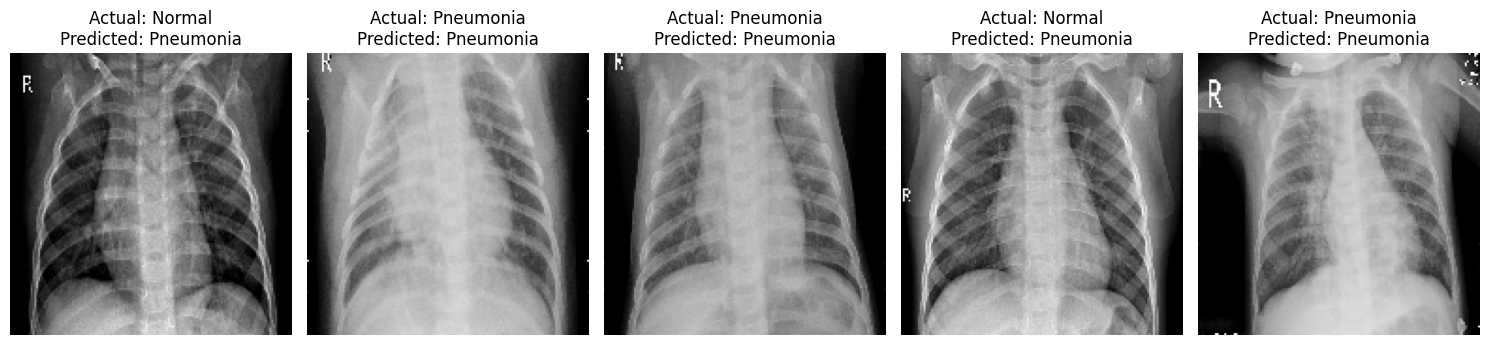

In [19]:
def display_random_test_images(X_test, y_test, y_pred, num_images=5):
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        idx = random.randint(0, len(X_test) - 1)
        plt.subplot(1, num_images, i + 1)
        
        plt.imshow(X_test[idx])
        plt.title(f"Actual: {'Pneumonia' if y_test[idx] == 1 else 'Normal'}\nPredicted: {'Pneumonia' if y_pred[idx] == 1 else 'Normal'}")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

display_random_test_images(X_test, y_test, y_pred)